In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
seed = 10000
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./images/',
    labels='inferred',
    image_size=(128, 128),
    validation_split=0.3,
    subset='training',
    seed=seed,
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./images/',
    labels='inferred',
    image_size=(128, 128),
    validation_split=0.3,
    subset='validation',
    seed=seed,
)

Found 1997 files belonging to 2 classes.
Using 1398 files for training.
Found 1997 files belonging to 2 classes.
Using 599 files for validation.


In [4]:
# preparing model for transfer learning
# using MobileNetV2 because it is also an image classification model, and it is in the tutorial I'm using (https://www.tensorflow.org/tutorials/images/transfer_learning)

IMAGE_SHAPE = (128, 128, 3)
base_classifier = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_classifier.trainable = False

# scaling for classifier model
temp_scaling_input = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)

# scaling for when this is converted to generator
# the generator outputs values in 0, 1. The model expects -1, 1
gen_scaling_input = tf.keras.layers.experimental.preprocessing.Rescaling(2, offset=-1)

pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)
x = temp_scaling_input(inputs)
x = base_classifier(x, training=False)
x = pooling_layer(x)
outputs = prediction_layer(x)
classifier_model = tf.keras.Model(inputs, outputs)

In [5]:
LEARNING_RATE = 1e-4

classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [6]:
EPOCHS = 10

history = classifier_model.fit(
    train_images,
    epochs=EPOCHS,
    validation_data=val_images,
)

Epoch 1/10
44/44 [==============================] - 13s 192ms/step - loss: 0.7173 - accuracy: 0.5629 - val_loss: 0.6324 - val_accuracy: 0.6411
Epoch 2/10
44/44 [==============================] - 9s 171ms/step - loss: 0.5475 - accuracy: 0.7110 - val_loss: 0.5018 - val_accuracy: 0.7563
Epoch 3/10
44/44 [==============================] - 9s 170ms/step - loss: 0.4367 - accuracy: 0.7954 - val_loss: 0.4114 - val_accuracy: 0.8047
Epoch 4/10
44/44 [==============================] - 9s 170ms/step - loss: 0.3585 - accuracy: 0.8519 - val_loss: 0.3475 - val_accuracy: 0.8531
Epoch 5/10
44/44 [==============================] - 9s 172ms/step - loss: 0.3016 - accuracy: 0.8813 - val_loss: 0.3009 - val_accuracy: 0.8831
Epoch 6/10
44/44 [==============================] - 9s 172ms/step - loss: 0.2598 - accuracy: 0.9041 - val_loss: 0.2664 - val_accuracy: 0.8982
Epoch 7/10
44/44 [==============================] - 9s 173ms/step - loss: 0.2278 - accuracy: 0.9256 - val_loss: 0.2396 - val_accuracy: 0.9215
Epoch

In [7]:
# making a generator model for generating images from random vectors

generator_model = tf.keras.models.Sequential()

V_WINDOW = 16
V_CONVOLUTIONS = 128
VECTOR_LENGTH = V_WINDOW*V_WINDOW*V_CONVOLUTIONS

generator_model.add(tf.keras.layers.InputLayer(input_shape=(VECTOR_LENGTH,)))
generator_model.add(tf.keras.layers.Reshape((V_WINDOW, V_WINDOW, V_CONVOLUTIONS)))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=64,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=32,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=3,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

print(generator_model.output_shape)

(None, 128, 128, 3)


In [8]:
# attaching the generator as input to the frozen classifier, to teach generator what classifier wants

base_classifier.trainable = False
pooling_layer.trainable = False
prediction_layer.trainable = False
gen_scaling_input.trainable = False

full_input = tf.keras.layers.Input(shape=(VECTOR_LENGTH,))
x = generator_model(full_input)
x = gen_scaling_input(x)
x = base_classifier(x, training=False)
x = pooling_layer(x)
full_output = prediction_layer(x)

full_model = tf.keras.Model(full_input, full_output)

In [9]:
LEARNING_RATE=1e-2

full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
VECTORS_COUNT = 10000

train_vectors = tf.random.normal((VECTORS_COUNT, VECTOR_LENGTH))
train_labels = tf.concat([tf.ones((int)(VECTORS_COUNT / 2)), tf.zeros((int)(VECTORS_COUNT / 2))], 0)

full_model.fit(
    x=train_vectors,
    y=train_labels,
    epochs=10,
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/10
219/219 [==============================] - 18s 70ms/step - loss: 0.6111 - accuracy: 0.7093 - val_loss: 1.3513 - val_accuracy: 0.0000e+00
Epoch 2/10
219/219 [==============================] - 14s 62ms/step - loss: 0.6117 - accuracy: 0.7143 - val_loss: 1.4867 - val_accuracy: 0.0000e+00
Epoch 3/10
219/219 [==============================] - 14s 64ms/step - loss: 0.6030 - accuracy: 0.7143 - val_loss: 1.3315 - val_accuracy: 0.0000e+00
Epoch 4/10
219/219 [==============================] - 14s 64ms/step - loss: 0.6009 - accuracy: 0.7123 - val_loss: 1.3603 - val_accuracy: 0.0000e+00
Epoch 5/10
219/219 [==============================] - 14s 65ms/step - loss: 0.6005 - accuracy: 0.7114 - val_loss: 1.3218 - val_accuracy: 0.0000e+00
Epoch 6/10
219/219 [==============================] - 14s 64ms/step - loss: 0.5998 - accuracy: 0.7143 - val_loss: 1.2945 - val_accuracy: 0.0000e+00
Epoch 7/10
219/219 [==============================] - 14s 63ms/step - loss: 0.5989 - accuracy: 0.7143 - val_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


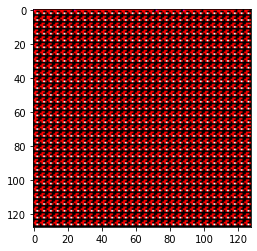

In [12]:
generated_images = generator_model(train_vectors[:10], training=False)

plt.imshow(generated_images[0])